---
title: "Analysis of iTunes Podcast Reviews"
format:
  html:
    toc: true
    code-fold: true
    code-summary: "Show the code"
---

### Imports and Options

In [1]:
from aux_functions import *

# from sqlalchemy_schemadisplay import create_schema_graph
# from sqlalchemy import create_engine, MetaData
from IPython.display import Image
import os
import duckdb
from tabulate import tabulate
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import seaborn as sns
from screeninfo import get_monitors
from collections import Counter
import numpy as np
from numerize.numerize import numerize
import sys
import random
from IPython.display import Markdown
import scipy.stats as stats
import plotly.io as pio

In [2]:
base_fig_width = 8
base_fig_height = 5
dpi = get_monitors()[0].width / (get_monitors()[0].width_mm / 25.4)*0.9
pio.renderers.default = "plotly_mimetype+notebook_connected"

##### Download and unzip the dataset:

In [3]:
# !kaggle datasets download -d thoughtvector/podcastreviews

In [4]:
# import zipfile

# with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
#     zip_ref.extractall()

##### Create a connection using duckdb:

In [5]:
con = duckdb.connect()
con.execute("INSTALL sqlite")
con.execute("ATTACH DATABASE 'database.sqlite'")

## Exploratory Data Analysis

### Database Overview

##### What are the tables and their columns?

In [6]:
# | label: tbl-database
# | tbl-cap: Tables and columns of the dataset.
Markdown(tabulate(
con.query(
            """--sql
SELECT table_name, GROUP_CONCAT(column_name) AS column_names FROM information_schema.columns GROUP BY table_name
"""
        ).to_df()
, showindex=False, headers="keys", tablefmt="pipe"))

| table_name   | column_names                                         |
|:-------------|:-----------------------------------------------------|
| runs         | run_at,max_rowid,reviews_added                       |
| podcasts     | podcast_id,itunes_id,slug,itunes_url,title           |
| categories   | podcast_id,category                                  |
| reviews      | podcast_id,title,content,rating,author_id,created_at |

#### What is the number of rows in each table?

In [7]:
table_names = (
    con.query(
        """--sql
SELECT table_name
FROM information_schema.tables
"""
    )
    .to_df()["table_name"]
    .to_list()
)

for table in table_names:
    print(
        table
        + ": "
        + str(
            numerize(
                con.query(
                    """--sql
        SELECT COUNT(*)
        FROM database.{}
        """.format(
                        table
                    )
                ).fetchone()[0]
            )
        )
    )


runs: 16
podcasts: 110.02K
categories: 212.37K
reviews: 2.07M


The category table has more entries than the podcast table suggesting that podcasts can be tagged in more than one category.

##### Are all podcasts accounted for in the categories table?

In [8]:
if not con.query(
    """--sql
SELECT p.podcast_id
FROM database.podcasts p
LEFT JOIN database.categories c ON p.podcast_id = c.podcast_id
WHERE c.podcast_id IS NULL
"""
).fetchall():
    # Query checks if there are any podcasts left out in the join, returns [] not.
    display(Markdown('Yes'))

Yes

All podcasts have at least one category assigned.

##### The number of categories of the podcasts:

In [9]:
con.query(
    """--sql
SELECT COUNT(DISTINCT category) FROM database.categories 
"""
).fetchone()[0]

110

### Podcast characteristics

#### Review number and rating distribution amongst podcasts

##### Extracting the number of reviews and average rating of each podcast:

In [10]:
review_stats_pod_agg = con.query(
    """--sql
SELECT r.podcast_id,
    p.title,
    COUNT(r.*) AS num_reviews,
    AVG(r.rating) AS average_rating
FROM database.reviews as r
    LEFT JOIN database.podcasts as p ON r.podcast_id = p.podcast_id
GROUP BY r.podcast_id,
    p.title
"""
).to_df()

##### Podcast review histograms:

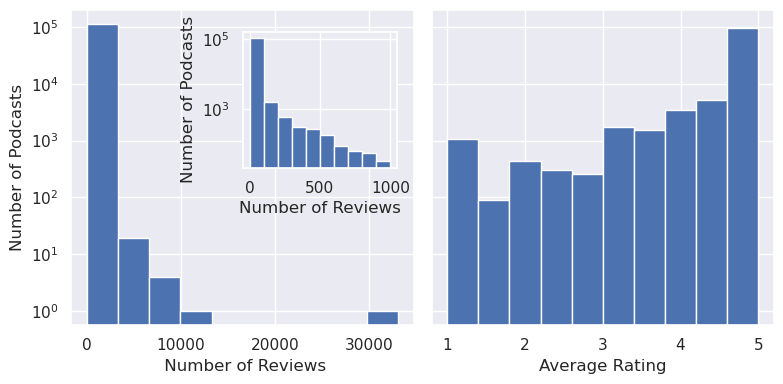

In [11]:
# | label: fig-reviews-pod
# | fig-cap: Histogram of the number of reviews each podcast has in a dataset (left). The frequency is in the y-axis is in a logarithmic scale. The inset on the left chart shows frequencies of podcasts that had less than a thousand reviews. Right the histogram of ratings with frequencies in log-scale.
sns.set()
# Figure setup
fig_reviews_pod, (ax_reviews_pod, ax_ratings_pod) = plt.subplots(
    1, 2, figsize=(base_fig_width, base_fig_height * 0.8), sharey=True
)
# Podcasts Histogram Inset
review_stats_pod_agg.hist("num_reviews", ax=ax_reviews_pod, bins=10)
ax_reviews_pod.set_yscale("log")
axis_titles(ax_reviews_pod, " Number of Reviews", "Number of Podcasts")

# Podcasts Histogram Inset
ax_reviews_pod_inset = ax_reviews_pod.inset_axes([0.5, 0.5, 0.45, 0.43])
review_stats_pod_agg.loc[review_stats_pod_agg["num_reviews"] < 1000].hist(
    "num_reviews", ax=ax_reviews_pod_inset
)
axis_titles(ax_reviews_pod_inset, "Number of Reviews", "Number of Podcasts")
ax_reviews_pod_inset.set_yscale("log")

# Rating Hist
review_stats_pod_agg.hist("average_rating", ax=ax_ratings_pod, bins=10)
axis_titles(ax_ratings_pod, "Average Rating")
ax_ratings_pod.set_yscale("log")

# Layout
fig_reviews_pod.tight_layout(w_pad=1)
plt.show()


There is a negative exponential distribution of the number of reviews that the podcasts are getting, with the majority having only several reviews as seen in @fig-reviews-pod. Yet there are podcasts with more than 30 thousand reviews. An exponential trend can also be seen in the ratings that the podcasts are getting. The majority of ratings are "5", with lower number progressively being rarer. The "1" rating is an exception, being higher than the neighbors. 

#### The category distribution of podcasts.

##### Extracting tagged categories for each podcast:

In [12]:
podcasts_categories = con.query(
    """--sql
    SELECT p.podcast_id, GROUP_CONCAT(c.category) AS category
    FROM database.podcasts p
    LEFT JOIN database.categories c ON p.podcast_id = c.podcast_id
    GROUP BY p.podcast_id
"""
).to_df()
podcasts_categories["category"] = podcasts_categories["category"].str.split(",")
podcasts_categories["num_categories"] = podcasts_categories["category"].apply(len)

Is there any missing data in the extraction?

In [13]:
podcasts_categories.isna().any()

podcast_id        False
category          False
num_categories    False
dtype: bool

##### How many different categories are the podcasts tagged in?

In [14]:
col_frequency_table(podcasts_categories, "num_categories", " Number of Categories")

Number of Categories,1,2,3,4,5,6,7,8
Frequency,44455,39443,16491,8809,658,147,18,3


Sample categories:

In [15]:
podcasts_categories["category"].to_frame().head(8)


,category
0,"[sports, arts]"
1,"[education-self-improvement, education]"
2,"[religion-spirituality, christianity]"
3,"[education-self-improvement, education]"
4,[business-entrepreneurship]
5,"[tv-film-tv-reviews, tv-film]"
6,"[health-fitness, comedy]"
7,[news]


The podcasts can be tagged in up to 8 categories, furthermore tags seem to have categories and sub categories. This might make the surface overview of the data complicated, therefore the categories will be aggregated by taking only the main category i.e. society-culture=culture. And merging some other similar categories like different religions into a single religion and spirituality category.

##### Aggregating the categories:

In [16]:
podcasts_categories["categories_agg"] = podcasts_categories["category"].apply(
    transform_category_list
)

Sample categories after aggregation:

In [17]:
podcasts_categories["categories_agg"].head(8).to_frame()


,categories_agg
0,"{arts, sports}"
1,{education}
2,{spirituality-religion}
3,{education}
4,{business}
5,{tv}
6,"{comedy, health}"
7,{news}


##### How many aggregated categories are the podcasts tagged in?

In [18]:
col_frequency_table(
    podcasts_categories["categories_agg"].apply(len).to_frame(),
    "categories_agg",
    " Number of Aggregated Categories",
)


Number of Aggregated Categories,1,2,3,4,5
Frequency,80562,28128,1254,77,3


#### How many times were podcasts tagged in each category?

##### Calculating the number of tags for each aggregated category:

In [19]:
cat_counter = Counter()
for cat in podcasts_categories["categories_agg"]:
    cat_counter.update(cat)
category_frequency = pd.DataFrame.from_dict(
    dict(cat_counter), orient="index", columns=["Frequency"]
).sort_values("Frequency", ascending=False)

##### Visualizing the results in a bar chart:

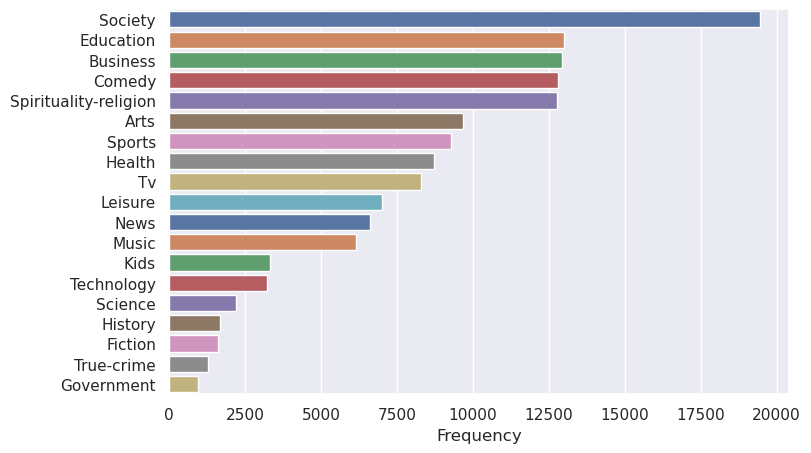

In [20]:
# | label: fig-cats-freq
# | fig-cap: The number of times each aggregated category was tagged in a description of a podcast.

fig_cats_freq, ax_cats_freq = plt.subplots(figsize=(base_fig_width, base_fig_height))
sns.barplot(
    x=category_frequency["Frequency"],
    y=category_frequency.index.str.capitalize(),
    ax=ax_cats_freq,
    palette="deep",
)
plt.show()


#### Category ratings

##### What is the average rating and number of reviews for podcasts in each category?

##### Fetching the number of ratings and the average rating of podcasts tagged in each aggregated category:

In [21]:
category_agg_names = category_frequency.index.to_list()
category_ratings = {}
for category in category_agg_names:
    id_list = ", ".join(
        f"'{id}'"
        for id in podcasts_categories[
            podcasts_categories["categories_agg"].apply(lambda x: category in x)
        ]["podcast_id"]
    )
    category_ratings[category] = con.query(
        f"""--sql
    SELECT COUNT(*) as num_ratings,
    AVG(rating) as avg_rating,
    stddev_pop(rating) as rating_std
    FROM database.reviews
    WHERE podcast_id IN ({ id_list })
        """
    ).fetchone()

In [22]:
category_ratings = pd.DataFrame.from_dict(category_ratings).T.rename(
    columns={0: "rating_count", 1: "average_rating", 2: "standard_deviation"}
)
category_stats = category_frequency.join(category_ratings)
category_stats["ratings_per_pod"] = (
    category_stats["rating_count"] / category_stats["Frequency"]
)
cat_colors = sns.color_palette("deep", len(category_stats))


In [23]:
# | label: fig-cat-overview
# | fig-cap: The average ratings of podcasts tagged in a category over the average number ratings a podcast tagged in that category received. The size of the point represent the total number of reviews podcasts tagged in the specific category had.
figure_cat_overview = px.scatter(
    category_stats,
    x="ratings_per_pod",
    y="average_rating",
    size="Frequency",
    hover_name=category_stats.index,
    width=base_fig_width * dpi,
    height=base_fig_height * dpi,
)
figure_cat_overview.update_layout(
    xaxis_title="Reviews per Podcast", yaxis_title="Average Rating"
)

default_plotly_margins(figure_cat_overview)

figure_cat_overview.show()

##### What are the podcasts with the most reviews?

In [24]:
# | label: tbl-popular_pods
# | tbl-cap: Podcasts with the most reviews
Markdown(
    tabulate(
        review_stats_pod_agg.sort_values("num_reviews", ascending=False)[
            ["title", "num_reviews"]
        ].head(5),
        showindex=False,
        headers=["Title",'Number of Reviews'],
        tablefmt="pipe",
    )
)

| Title                                                         |   Number of Reviews |
|:--------------------------------------------------------------|--------------------:|
| Crime Junkie                                                  |               33104 |
| My Favorite Murder with Karen Kilgariff and Georgia Hardstark |               10675 |
| Wow in the World                                              |                9698 |
| The Ben Shapiro Show                                          |                8248 |
| Story Pirates                                                 |                7389 |

### Reviewer Characteristics

#### How many reviewers left reviews?

In [25]:
Markdown(numerize(
    con.query(
        """--sql
    SELECT COUNT(DISTINCT author_id)
    FROM database.reviews
"""
    ).fetchone()[0]
))


1.48M

#### What is the distribution of the number of reviews each reviewer wrote?

##### Extracting the number of reviews per user:

In [26]:
review_per_user = con.query(
    """--sql
SELECT
FLOOR(rating_count/1)*1 AS num_reviews,
COUNT(*) as count
FROM (
  SELECT author_id, COUNT(rating) AS rating_count
  FROM database.reviews
  GROUP BY author_id
) AS subquery
GROUP BY 1
ORDER BY 1
"""
).to_df()

##### Binning the numbers into custom bins:

In [27]:
rev_per_user_bins = np.concatenate(
    (
        np.arange(0, 10),
        np.arange(11, 101, 10),
        np.arange(101, max(review_per_user["num_reviews"]) + 100, 100),
    )
)

review_per_user["reviews_binned"] = pd.cut(
    review_per_user["num_reviews"], bins=rev_per_user_bins
)

##### Histogram of the number of reviews each user wrote:

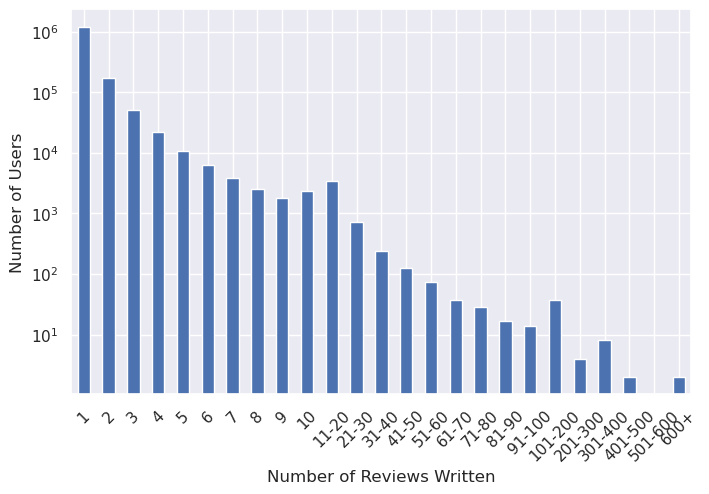

In [28]:
# | label: fig-rev-per-user
# | fig-cap: The amount of users that wrote a certain number of reviews.

# Figure Setup
fig_rev_per_user, ax_rev_per_user = plt.subplots(
    figsize=(base_fig_width, base_fig_height)
)

# Plot
review_per_user.groupby("reviews_binned")["count"].sum().to_frame().plot.bar(
    ax=ax_rev_per_user, legend=False
)
# Scale
ax_rev_per_user.set_yscale("log")

# Bin labels
bin_labels = []
for i in range(1, 11):
    bin_labels.append(str(i))
for i in range(11, 101, 10):
    bin_labels.append(f"{i}-{i+9}")
for i in range(101, 700, 100):
    bin_labels.append(f"{i}-{i+99}")
bin_labels[-1] = "600+"
ax_rev_per_user.set_xticklabels(bin_labels, rotation=45)

# Titles
axis_titles(ax_rev_per_user, "Number of Reviews Written", "Number of Users")

plt.show()

As seen in @fig-rev-per-user most of the users wrote one or two reviews, yet there is also a number of people that wrote significantly more.

##### Is there a correlation between the number of reviews and a user wrote and the average rating given?

In [29]:
Markdown("Pearsons r: "+str(round(
con.query(
    """--sql
SELECT corr(rating_count, avg_rating)
FROM (
SELECT author_id, COUNT(rating) AS rating_count, AVG(rating) AS avg_rating
FROM database.reviews
GROUP BY author_id) AS ratings
"""
).fetchone()[0],3)))

Pearsons r: -0.043

No significant correlation was observed.

#### What is the distribution of ratings amongst most prolific users (>10 reviews)?

##### Fetching the information about the reviews from users that rated more than 10 times:

In [30]:
users_many_reviews = con.query(
    """--sql
SELECT *
FROM (
SELECT author_id, COUNT(rating) AS rating_count, AVG(rating) AS avg_rating
FROM database.reviews
GROUP BY author_id) AS ratings
WHERE ratings.rating_count>10
"""
).to_df()


##### Scatterplot visualization:

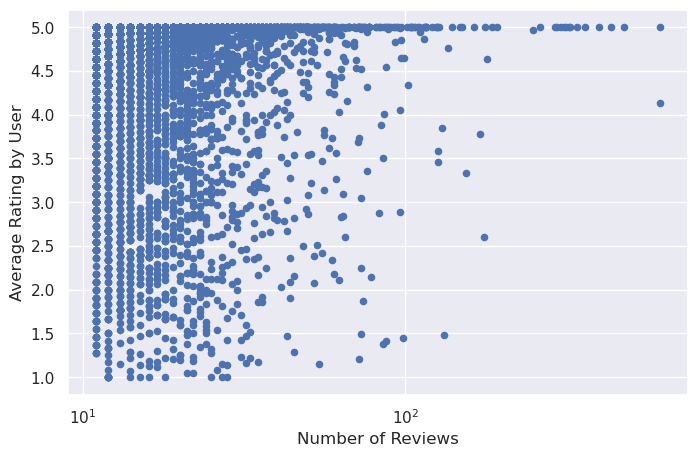

In [31]:
# | label: fig-user-scatter
# | fig-cap: The average rating given by a user over the number of reviews that the user wrote.
fig_rating_scatter, ax_rating_scatter = plt.subplots(
    figsize=(base_fig_width, base_fig_height)
)
users_many_reviews.plot.scatter("rating_count", "avg_rating", ax=ax_rating_scatter)
ax_rating_scatter.set_xscale("log")
axis_titles(ax_rating_scatter, "Number of Reviews", "Average Rating by User")
plt.show()


The majority of users that wrote hundreds of reviews gave exclusively "5" point ratings. This raises suspicion of bot activity.

#### What were some of the reviews that a user who wrote more than 600 reviews gave?

##### Getting 5 random reviews of a specific user:

In [32]:
prolific_user = users_many_reviews.sort_values(
    ["rating_count", "avg_rating"], ascending=False
).iloc[0, 0]
random.seed(1)
bot_comments = con.query(
    """--sql
SELECT title, content
FROM database.reviews
WHERE author_id = '{}'
ORDER BY RANDOM()
LIMIT 5
""".format(
        prolific_user
    )
).to_df()

##### The reviews were:

In [33]:
for i, comment in bot_comments.iterrows():
    display(Markdown("Title: " + comment[0] + " Comment: " + comment[1] + "<br />"))

Title: Awesome Podcast!!! Comment: Dr. Willie, host of the Dr. Willie Jolley's Wealthy Ways podcast, highlights all aspects of wealth  and more in this can’t miss podcast!  The host and expert guests offer insightful advice and information that is helpful to anyone that listens!<br />

Title: Awesome Podcast!!! Comment: Aymann, host of the Man Up podcast, highlight all aspects of relationships, life changes and more in this can’t miss podcast!  The host and expert guests offer insightful advice and information that is helpful to anyone that listens!<br />

Title: Awesome Podcast!!! Comment: Erik, host of the Village Global's Venture Stories podcast, highlights all aspects of entrepreneurs, investors and tech industry leaders and more in this can’t miss podcast!  The host and expert guests offer insightful advice and information that is helpful to anyone that listens!<br />

Title: Awesome Podcast!!! Comment: The host of the Planet Money podcast, highlight all aspects of news and more in this can’t miss podcast!  The host and expert guests offer insightful advice and information that is helpful to anyone that listens!<br />

Title: Awesome Podcast!!! Comment: Carrie, host of The Executive Innovation Sho‪w‬ podcast, highlights all aspects of technology and more in this can’t miss podcast!  The host and expert guests offer insightful advice and information that is helpful to anyone that listens!<br />

All of the reviews follow an identical pattern and since this user wrote more than six hundred of these, we can suspect that it's a bot, along with some of the other users.

## User Negativity Analysis

The underlying premise of this section posits that certain authors might exhibit a consistent tendency to include a higher proportion of negative reviews compared to others. To examine this premise, we focus on a specific population of <b>users who have submitted between 5 and 10 reviews</b>. The selection of this range is arbitrary but serves as a means to identify users who have provided a reasonable number of reviews, indicating genuine engagement rather than automated or excessively frequent reviewing. Moreover, <b>users who have exclusively rated items with either a "5" or a "1" have been excluded</b> from this population of interest.


To investigate this premise, three distinct statistical experiments were devised to address the following inquiries:

1. Is there a higher likelihood for users who have given a "1" rating at least once to subsequently provide another negative rating, compared to those who have not assigned a "1" rating?
2. Do users who have given at least one "1" rating tend to give lower average ratings overall, compared to users who have not assigned a "1" rating?
3. What is the proportion of users who exclusively provide negative ratings, without assigning any positive ratings?

##### Gathering the required information about the population of interest.

In [34]:
average_reviewer = con.query(
    """--sql
SELECT *
FROM (
SELECT author_id, COUNT(rating) AS rating_count, AVG(rating) AS avg_rating, GROUP_CONCAT(rating) AS user_ratings
FROM database.reviews
GROUP BY author_id) AS ratings
WHERE (ratings.rating_count BETWEEN 3 AND 10)
AND ratings.avg_rating !=5
AND ratings.avg_rating !=1
"""
).to_df()

# Changing the data format
average_reviewer["user_ratings"] = average_reviewer["user_ratings"].apply(
    lambda x: np.fromstring(x, dtype=int, sep=",")
)

### Are Users that gave a "1" rating once more likely to rate badly again than those who did not?

In this experiment, the users were segregated into two distinct groups based on their rating behavior: those who had assigned a "1" rating at least once, referred to as "<b>1-raters</b>," and those who had never provided a "1" rating, referred to as "<b>1-non-raters</b>." To ensure that the initial "1" rating did not bias the results, the lowest-rated review from each user was excluded. Subsequently, the population was further divided into two subgroups: those who had given at least one additional rating lower than "3" (either "1" or "2") and those who had not. The disparity in proportions between the individuals who had given another negative rating and those who had not, among both the 1-raters and 1-non-raters, was then calculated.

##### Splitting the users into two groups:

In [35]:
average_reviewer["rated_1"] = average_reviewer["user_ratings"].apply(
    lambda lst: 1 in lst
)

##### Removing a single worst rating from every user's list of ratings:

In [36]:
average_reviewer["ratings_updated"] = average_reviewer["user_ratings"].apply(
    lambda x: np.delete(x, x.argmin())
)

##### Identifying those who gave one more bad rating:

In [37]:
average_reviewer["rated_bad_again"] = average_reviewer["ratings_updated"].apply(
    lambda x: np.any(x < 3)
)


average_user_n = len(average_reviewer)

#### How many people gave at least one "1" rating?

In [38]:
average_reviewer["rated_1"].value_counts()

True     19163
False    17873
Name: rated_1, dtype: int64

#### What is the difference in proportions of people who gave another bad rating between "1-raters" and "1-non-raters"?

##### What are the proportions of users who rated badly again between the two groups?

In [39]:
group_1raters_n = (
    len(average_reviewer.loc[average_reviewer["rated_1"], "rated_bad_again"])
)

group_1nonraters_n = (
    len(average_reviewer.loc[
        ~average_reviewer["rated_1"], "rated_bad_again"
    ])
)

group_1raters_p = (
    average_reviewer.loc[average_reviewer["rated_1"], "rated_bad_again"].value_counts()[
        True
    ]
    / group_1raters_n
)

group_1nonraters_p = (
    average_reviewer.loc[
        ~average_reviewer["rated_1"], "rated_bad_again"
    ].value_counts()[True]
    / group_1nonraters_n
)

Markdown(
    f"Group 1-raters p = {round(group_1raters_p,2)} <br />Group-1-non-raters p = {round(group_1nonraters_p, 2)}"
)

Group 1-raters p = 0.51 <br />Group-1-non-raters p = 0.06

##### Calculating the standard error:

In [40]:
low_ratings_se=np.sqrt(
    (group_1raters_p*(1-group_1raters_p)/group_1raters_n)+(group_1nonraters_p*(1-group_1nonraters_p)/group_1nonraters_n)    
    )

##### Calculating the margin of error:

In [41]:
low_ratings_er=stats.norm.ppf(0.95)*low_ratings_se

To analyze the outcomes, the critical values from the z-distribution were employed, given that the results were binary (boolean) and the population size was deemed sufficiently large. As it was established that one proportion is anticipated to be greater than the other, a one-tailed critical value coefficient was utilized in the analysis.

##### What is the difference in the chance that a user will give another bad rating between "1-raters" and "1-non-raters", with a 95% confidence:

In [42]:
Markdown(
    f"""The difference is between 
{round((group_1raters_p-group_1nonraters_p-low_ratings_er)*100,1)}%
and {round((group_1raters_p-group_1nonraters_p+low_ratings_er)*100,1)}%"""
)

The difference is between 
43.9%
and 45.3%

When one of the proportions is small in absolute terms, relying solely on the difference in proportions may not provide a complete picture. Instead, calculating the ratio of proportions offers a better understanding of the disparity between the populations. Using a ratio allows us to compare the proportions and assess the relative magnitude of the difference, providing a more nuanced interpretation of the results.

#### What is the ratio of the proportions of users who gave another low rating between 1-raters and 1-non-raters:

##### Katz logarithmic 95% confidence intervals for the ratio of population proportions:

In [43]:
proportion_ratio=stats.contingency.relative_risk(
    int(group_1raters_p * group_1raters_n),
    group_1raters_n,
    int(group_1nonraters_p * group_1nonraters_n),
    group_1nonraters_n,
)
Markdown(f"""The proportion of people who gave another bad rating is 
         {str(round(proportion_ratio.confidence_interval(0.95)[0],1))} to
         {str(round(proportion_ratio.confidence_interval(0.95)[1],1))} 
         times larger in "1-raters" than "1-non-raters" """)

The proportion of people who gave another bad rating is 
         7.5 to
         8.4 
         times larger in "1-raters" than "1-non-raters" 

##### What are the odds ratio of another bad rating occurring in the two groups?

In [44]:
bad_rates_con_tab = [
    [
        int(group_1raters_p * group_1raters_n),
        int(group_1nonraters_p * group_1nonraters_n),
    ],
    [
        int((1 - group_1raters_p) * group_1raters_n),
        int((1 - group_1nonraters_p) * group_1nonraters_n),
    ],
]
bad_rates_odds = stats.contingency.odds_ratio(bad_rates_con_tab)

Markdown(f"""The odds of at least one more bad rating are
         {str(round(bad_rates_odds.confidence_interval(0.95)[0],1))} to
         {str(round(bad_rates_odds.confidence_interval(0.95)[1],1))}
         times more likely to occur in the "1-rater" group
         """)


The odds of at least one more bad rating are
         14.2 to
         16.2
         times more likely to occur in the "1-rater" group
         

##### Experiment Summary
This experiment does have an inherent flaw from a probability perspective. The "1-non-raters" group has one less option for assigning a bad rating, as they only have the option of rating as "2" instead of both "1" and "2". This discrepancy implies that, if ratings were entirely random, the odds of another bad rating would be almost twice as high in the "1-raters" group. However, observational logic suggests that assigning a bad rating should be a rare and independent event.

Interestingly, the results of this experiment reveal a significant difference in proportions between users who gave another bad rating in the "1-raters" and "1-non-raters" groups, far grater than the expected default two times difference in odds. This finding supports the premise that certain individuals tend to consistently leave more negative ratings. Despite the flaw in the probability perspective, the experiment's outcomes provide evidence for the hypothesis that some users exhibit a tendency to consistently provide unfavorable reviews.

### Is the average of other ratings between "1-raters" and "1-non-raters" different?

This section examines the disparity in means of ratings between the two groups established in the initial experiment. The average ratings were calculated from the lists with the single worst rating removed for each user in both groups. By comparing the means of ratings, we aim to assess whether there is a significant difference in the average ratings between the two groups.

##### Calculating the average rating for each user:

In [45]:
average_reviewer["avg_rating_updated"] = average_reviewer["ratings_updated"].apply(
    lambda x: np.mean(x)
)

##### Calculating the population averages:

In [46]:
group_1raters_mean=average_reviewer.loc[average_reviewer['rated_1']==True,'avg_rating_updated'].mean()
group_1nonraters_mean=average_reviewer.loc[average_reviewer['rated_1']==False,'avg_rating_updated'].mean()

##### Average rating distribution between the two groups:

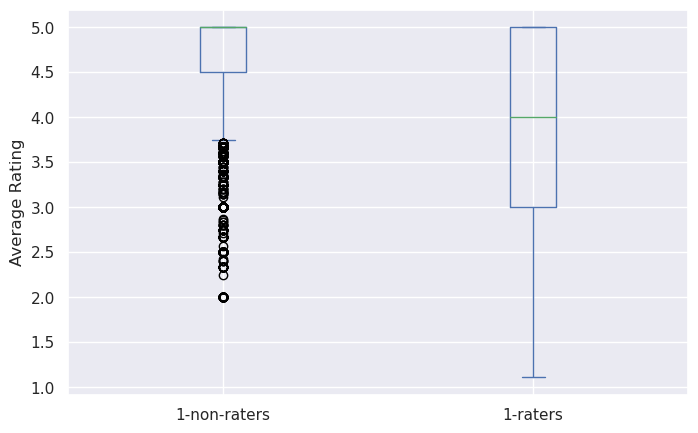

In [47]:
# | label: fig-user-rating-means
# | fig-cap: Box plots of average ratings by distinct users in both groups.
fig_user_rating_means,ax_user_rating_means=plt.subplots(figsize=(base_fig_width,base_fig_height))
average_reviewer.plot.box(column='avg_rating_updated',by='rated_1',ax=ax_user_rating_means)
axis_titles(ax_user_rating_means,ytitle='Average Rating')
ax_user_rating_means.set_xticklabels(('1-non-raters', '1-raters'))
plt.show()

From the distribution of average ratings shown in @fig-user-rating-means it is clear that the ratings tend to be lower and more deviated from the mean in "1-raters". To establish a more precise difference the difference in means with a 95% confidence will be calculated.

##### Calculating the standard deviations between the groups:

In [48]:
group_1raters_std=average_reviewer.loc[average_reviewer['rated_1']==True,'avg_rating_updated'].std()
group_1nonraters_std=average_reviewer.loc[average_reviewer['rated_1']==False,'avg_rating_updated'].std()
Markdown(f"""Group 1-raters Standard deviation: {round(group_1raters_std,2)}<br />
Group 1-non-raters Standard deviation: {round(group_1nonraters_std,2)}""")

Group 1-raters Standard deviation: 1.08<br />
Group 1-non-raters Standard deviation: 0.54

##### Calculating the Margin of error 95% confidence:

In [49]:
avg_rate_dif_me = (
    stats.norm.ppf(0.95)
    * (group_1nonraters_mean - group_1raters_mean)
    * np.sqrt(
        (group_1raters_std / group_1raters_n)
        + (group_1nonraters_std / group_1nonraters_n)
    )
)

##### The difference in mean rating between Groups 1-raters and 1-non-raters with 95% confidence:

In [50]:
Markdown(
    f"""The mean average rating of 1-raters is between 
{round((group_1nonraters_mean-group_1raters_mean-avg_rate_dif_me),2)}
and {round((group_1nonraters_mean-group_1raters_mean+avg_rate_dif_me),2)}
lower than that of 1-non-raters.
"""
)

The mean average rating of 1-raters is between 
0.79
and 0.81
lower than that of 1-non-raters.


##### Experiment summary
The average rating of 1-raters is significantly lower than that of 1-non-raters, which also supports the initial premise.

### What is the percentage of people that only leave bad ratings ( below 3)?{#sec-only_bad}

##### Identifying the users who only left ratings "1" and "2"

In [51]:
average_reviewer["only_bad"] = average_reviewer["user_ratings"].apply(
    lambda x: np.all(x < 3)
)

##### Calculating the proportion

In [52]:
only_bad_p = average_reviewer["only_bad"].value_counts()[1] / average_user_n
Markdown(
    f"""The proportion of users who only left ratings of "1" and "2" is
     {round(only_bad_p*100,2)}%."""
)

The proportion of users who only left ratings of "1" and "2" is
     2.17%.

##### Calculating the margin of error.

In [53]:
only_bad_me=stats.norm.ppf((1 + 0.95)/2)*np.sqrt(only_bad_p*(1-only_bad_p)/average_user_n)

##### Result:

In [54]:
Markdown(f"""
There is between {round((only_bad_p-only_bad_me)*100,2)}%
and {round((only_bad_p+only_bad_me)*100,2)}% of users that
only left ratings "1" and "2"
""")


There is between 2.02%
and 2.31% of users that
only left ratings "1" and "2"


##### Experiment summary
There are 2.0% to 2.3% percent of users who only left bad ratings. Keeping in mind that this is from a population that left 5 to 10 ratings, this is a significant amount of users that only down rank certain podcasts and not necceraly contribute to an objective evaluation of their quality.

##### Data Preparation for Looker Studio

In [55]:
sad_users=",".join([f"'{id}'" for id in average_reviewer.loc[average_reviewer['only_bad'], 'author_id']])

# podcasts rated by users who only left bad ratings
pods_rated_by_sads=con.execute(
        f"""--sql
    SELECT DISTINCT podcast_id
    FROM database.reviews
    WHERE author_id IN ({sad_users})
        """
).fetchnumpy()['podcast_id']

pods_rated_by_sads_full=podcasts_categories.loc[podcasts_categories['podcast_id'].isin(pods_rated_by_sads)]

# counting the number of times each category was tagged in podcasts rated by sad users
cat_by_sads_counter = Counter()
for cat in pods_rated_by_sads_full["categories_agg"]:
    cat_by_sads_counter.update(cat)
cats_rated_by_sads = pd.DataFrame.from_dict(
    dict(cat_by_sads_counter), orient="index", columns=["Frequency"]
).sort_values("Frequency", ascending=False)

# Exporting to csv
cats_rated_by_sads=cats_rated_by_sads.join(category_frequency,rsuffix='_Full')
cats_rated_by_sads.index.name='Category'
cats_rated_by_sads.to_csv('cats_by_sads.csv')

::: {#fig-cats-by-sads}
<iframe width="800" height="500" src="https://lookerstudio.google.com/embed/reporting/c71f2848-3e5f-48c4-b46e-0a8fbe0da22b/page/knaSD" frameborder="0" style="border:0" allowfullscreen></iframe> 
Top categories rated by negative users identified in @sec-only_bad . The bars display the percentage of reviews left by the negative users when compared to the total amount of reviews for that category.
:::

## Rating Polarization Analysis


The underlying premise of this section posits that podcasts centered around certain topics, such as politics, may exhibit a higher degree of polarization in user ratings. This polarization suggests that such podcasts are more likely to receive a significant number of very positive or very negative ratings, while receiving fewer ratings in the moderate range. This phenomenon may indicate that user evaluations are influenced more by personal biases rather than the quality of the podcasts.

To examine this premise, a new metric called "<b>polarization points</b>" was introduced. This metric assigned two points for each "1" or "5" rating, one point for each "2" or "4" rating, and zero points for "3" ratings. The distribution of these polarization points across various categories was then evaluated. By analyzing this distribution, we aim to assess whether podcasts with specific topics, such as politics, exhibit a higher concentration of extreme ratings and a lower presence of moderate ratings, supporting the notion of polarization in user evaluations.

##### Getting the list of non aggregated category names:

In [56]:
topics_arr=con.execute(
    f"""--sql
        SELECT DISTINCT category
        FROM database.categories
            """).fetchnumpy()

Getting the average rating, the number of podcasts, the standard deviation of ratings, and the frequency of ratings in each category:

In [57]:
topic_stats={}
for topic in topics_arr['category']:
    topic_stats[topic]=con.execute(
    f"""--sql
SELECT AVG(subq.rating) AS average_rating,
       COUNT(subq.rating) AS num_podcasts,
       stddev_pop(subq.rating) AS rating_std,
       GROUP_CONCAT(DISTINCT grouped_subquery.rating) AS ratings,
       GROUP_CONCAT(DISTINCT grouped_subquery.rating_frequency) AS rating_frequencies
FROM (
  SELECT rating, COUNT(*) AS rating_frequency
  FROM database.reviews
  WHERE podcast_id IN (
    SELECT DISTINCT podcast_id
    FROM database.categories
    WHERE category = '{topic}'
  )
  GROUP BY rating
) AS grouped_subquery,
(
  SELECT rating
  FROM database.reviews
  WHERE podcast_id IN (
    SELECT DISTINCT podcast_id
    FROM database.categories
    WHERE category = '{topic}'
  )
) AS subq

            """
).fetchone()
    
topic_stats=pd.DataFrame.from_dict(topic_stats).T
topic_stats.columns=['avg_rating','n','std','ratings','freq']
topic_stats[['ratings','freq']]=topic_stats[['ratings','freq']].applymap(
    lambda x: np.fromstring(x, dtype=int, sep=",")
    )

It should be noted that since podcasts can be tagged in several different topics, some of the reviews are counted in repeatedly in different topics.

##### Calculating polarization points for each category:

In [58]:
topic_stats["pol_points"] = topic_stats.apply(
    lambda row: pol_points(row["ratings"], row["freq"]), axis=1
)

##### Calculating the margin of error for the average of ratings in each category:

In [59]:
topic_stats['ME']=stats.norm.ppf(((1 + 0.95) / 2))*topic_stats['std']/(topic_stats['n']**0.5)
topic_stats.index.name='topic'
topic_stats['avg_rating']=topic_stats['avg_rating'].astype(float)

##### The top topics by polarization points:

In [60]:
# | label: tbl-pol-point
# | tbl-cap: Topic with most polarization points.
Markdown(
    tabulate(
        topic_stats[['avg_rating','pol_points']]
        .sort_values("pol_points", ascending=False)
        .head(),
        showindex=True,
        headers="keys",
        tablefmt="pipe",
    )
)

| topic                     |   avg_rating |   pol_points |
|:--------------------------|-------------:|-------------:|
| sports-rugby              |      4.98802 |      1.98802 |
| business-non-profit       |      4.90117 |      1.97354 |
| business-entrepreneurship |      4.90838 |      1.97348 |
| business-marketing        |      4.9371  |      1.97243 |
| hinduism                  |      4.86036 |      1.97196 |

Upon closer examination, it appears that the topics with the highest polarization points do not align with an intuitive observational perspective, as they seem to be neutral topics. Additionally, these topics also exhibit remarkably high average ratings. Considering that the majority of ratings are "5," as demonstrated in @fig-reviews-pod, it is conceivable that a positive correlation exists between the polarization points and the average rating. This correlation could potentially obscure the true results.

To investigate this relationship further, a more detailed analysis is conducted using a linear fit. This analysis allows for the exploration of any outliers that do not conform to the expected trend. By closely examining these outliers, we aim to gain a deeper understanding of the relationship between polarization points and average ratings and to determine whether there are any exceptional cases that deviate from the overall pattern. This approach provides a more comprehensive assessment of the relationship between polarization points and ratings, shedding light on any potential nuances that may exist.

##### Creating a scatter plot of average ratings and polarization points with a linear fit:

In [61]:
fig_topics_scatter = px.scatter(
    topic_stats,
    "avg_rating",
    "pol_points",
    hover_name=topic_stats.index,
    trendline="ols",
    width=base_fig_width * dpi,
    height=base_fig_height * dpi,
    labels={"avg_rating": "Average Rating", "pol_points": "Review Polarization Points"},
)
pol_line_results = px.get_trendline_results(fig_topics_scatter)["px_fit_results"][0]

##### The R-square of the linear fit:

In [62]:
round(pol_line_results.rsquared,3)

0.834

##### Evaluating the distribution of residuals from the fit:

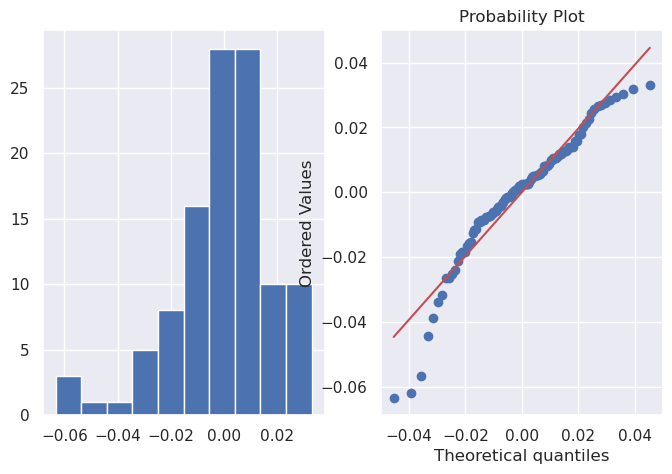

In [63]:
# | label: fig-line-resids
# | fig-cap: The distribution of residuals of points from the linear fit is displayed on the left. The right chart displays the quantile-quantile plot of the residuals.
fig_line_resids, (ax_resid_hist, ax_resid_qq) = plt.subplots(
    1, 2, figsize=(base_fig_width, base_fig_height)
)
ax_resid_hist.hist(pol_line_results.resid)
dist_metrics = {}
dist_metrics["shape", "loc", "scale"] = stats.norm.fit(pol_line_results.resid)
probplot(
    pol_line_results.resid,
    dist="norm",
    sparams=(dist_metrics["shape", "loc", "scale"]),
    plot=ax_resid_qq,
)
plt.show()

The distribution is skewed left, meaning that there are more extreme outliers on the "less polarized" side of the fit. Due to the skewness the t-distribution critical value will be used.

##### Calculating the root mean squared error of residuals and margin of error:

In [64]:
pol_line_RMSE = np.sqrt(np.mean(pol_line_results.resid**2))
pol_line_ME = stats.t.ppf((1 + 0.90) / 2, len(topic_stats)-2) * pol_line_RMSE

##### Generating margin of error lines:

In [65]:
line_er_x=np.linspace(topic_stats['avg_rating'].min(),5,100)
line_fit=np.polyfit(topic_stats['avg_rating'].values,topic_stats['pol_points'].values,1)
positive_line_er_y=np.poly1d(line_fit)(line_er_x)+pol_line_ME
negative_line_er_y=np.poly1d(line_fit)(line_er_x)-pol_line_ME

##### The final plot:

In [66]:
# | label: fig-topics-scatter
# | fig-cap: A scatter plot of category polarization point over the average rating of podcasts tagged in that category. The blue trend line is a linear fit, the grey dashed lines signify the 90% confidence margin of error of point distance from the model.

pol_pos_line=px.line(x=line_er_x,y=positive_line_er_y).data[0]
pol_pos_line.update(line=dict(color='grey',dash='dash'))

pol_neg_line=px.line(x=line_er_x,y=negative_line_er_y).data[0]
pol_neg_line.update(line=dict(color='grey',dash='dash'))

fig_topics_scatter.add_trace(pol_pos_line)
fig_topics_scatter.add_trace(pol_neg_line)

default_plotly_margins(fig_topics_scatter)

fig_topics_scatter.show()


##### Most polarizing topics according to residuals away from the linear fit:

In [67]:
# | label: tbl-pol-topics
# | tbl-cap: Most polarizing topics by distance from the fit.
topic_stats["residuals"] = topic_stats["pol_points"] - np.poly1d(line_fit)(
    topic_stats["avg_rating"]
)
Markdown(
    tabulate(
        topic_stats["residuals"]
        .to_frame()
        .sort_values("residuals", ascending=False)
        .head(),
        showindex=True,
        headers="keys",
        tablefmt="pipe",
    )
)

| topic                         |   residuals |
|:------------------------------|------------:|
| society-culture-relationships |   0.0330041 |
| news-politics                 |   0.0319741 |
| news-news-commentary          |   0.0302625 |
| science-life-sciences         |   0.0295444 |
| sports-wrestling              |   0.0283977 |

##### Least polarizing:

In [68]:
# | label: tbl-non_pol-topics
# | tbl-cap: Least polarizing topics by distance from the fit.
topic_stats["residuals"] = topic_stats["pol_points"] - np.poly1d(line_fit)(
    topic_stats["avg_rating"]
)
Markdown(
    tabulate(
        topic_stats["residuals"]
        .to_frame()
        .sort_values("residuals", ascending=True)
        .head(),
        showindex=True,
        headers="keys",
        tablefmt="pipe",
    )
)

| topic                   |   residuals |
|:------------------------|------------:|
| fiction-science-fiction |  -0.0633455 |
| sports-tennis           |  -0.0620044 |
| fiction-drama           |  -0.0566427 |
| sports-volleyball       |  -0.0443606 |
| sports-cricket          |  -0.0388314 |

##### Section summary
The data presented in @fig-topics-scatter supports the notion that the most polarizing topics include news-politics and news-commentary. These topics are often associated with a higher likelihood of polarization due to the diverse opinions and perspectives they encompass. On the other hand, the least polarizing topics, such as different sports shows and fiction, align with our observational intuition as they generally evoke less controversy and strong opinions.